In [166]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from pandas import DataFrame
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import xgboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from optuna import create_study
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import StackingClassifier

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [167]:
data = pd.read_csv('winequality-red.csv', sep = ';')

1.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [168]:
y = data.quality
X = data.drop(columns='quality')

learn_df, test_df, learn_y, test_y = train_test_split(X, y, test_size=0.3)

2.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [169]:
tree_classifier_model = DecisionTreeClassifier()
tree_classifier_model.fit(learn_df, learn_y)
tree_classifier_predict = tree_classifier_model.predict(test_df)
tree_accuracy = accuracy_score(test_y, tree_classifier_predict)
print('Accuracy for DecisionTreeClassifier: ', tree_accuracy)

Accuracy for DecisionTreeClassifier:  0.6208333333333333


In [170]:
bc_with_trees = BaggingClassifier(base_estimator=tree_classifier_model, n_estimators=100)
bc_with_trees.fit(learn_df, learn_y)
bc_with_trees_predict = bc_with_trees.predict(test_df)
bc_with_trees_accuracy = accuracy_score(test_y, bc_with_trees_predict)
print('Accuracy for BaggingClassifier with 100 trees: ', bc_with_trees_accuracy)

Accuracy for BaggingClassifier with 100 trees:  0.66875


In [171]:
def get_random_forest_accuracy_with_n_trees(trees_count:int):
    random_forest_model = RandomForestClassifier(n_estimators=trees_count)
    random_forest_model.fit(learn_df, learn_y)
    random_forest_predict = random_forest_model.predict(test_df)
    random_forest_accuracy = accuracy_score(test_y, random_forest_predict)
    return random_forest_accuracy

random_forest_accuracy = get_random_forest_accuracy_with_n_trees(100)

print('Accuracy for RandomForestClassifier with n_estimators=100: ', random_forest_accuracy)

Accuracy for RandomForestClassifier with n_estimators=100:  0.6708333333333333


Вывод: Bagging дает лучшие результаты, чем простое применение DecisionTreeClassifier,
однако RandomForestClassifier, использующий внутри тот же DecisionTreeClassifier дает ещё лучшие результаты

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [172]:
accuracy_by_n = DataFrame(columns=['n_trees', 'accuracy'])

for a in range(1,25):
    current_model = RandomForestClassifier(n_estimators=a*200)
    current_n = a*200
    current_accuracy = get_random_forest_accuracy_with_n_trees(current_n)
    row_df = DataFrame.from_dict({'n_trees': [current_n], 'accuracy': [current_accuracy]})
    accuracy_by_n = pd.concat([accuracy_by_n, row_df])
accuracy_by_n = accuracy_by_n.reset_index(drop=True)
accuracy_by_n = accuracy_by_n.set_index('n_trees')
accuracy_by_n.head()

/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,accuracy
n_trees,
200,0.670833
400,0.668750
600,0.670833
800,0.670833
1000,0.670833


<AxesSubplot:xlabel='n_trees'>

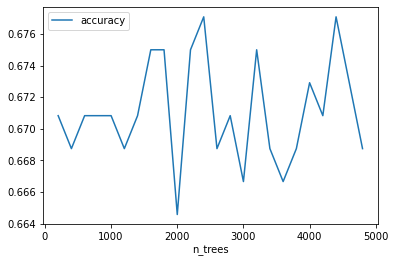

In [173]:
accuracy_by_n.plot()

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [174]:
sk_learn_gradient_boosting_model = GradientBoostingClassifier()
cross_val_score_sk_gradient_boosting = cross_val_score(sk_learn_gradient_boosting_model, learn_df, learn_y, scoring='accuracy')
print(f'Cross_val_score for gradient boosting sklearn: {cross_val_score_sk_gradient_boosting}')

print(f'xgboost library version {xgboost.__version__}')
xgboost_gradient_boosting_model = xgboost.XGBClassifier()

le = LabelEncoder()
learn_y_labeled = le.fit_transform(learn_y)
test_y_labeled = le.fit_transform(test_y)

cross_val_score_xgboost_gradient_boosting = cross_val_score(xgboost_gradient_boosting_model, learn_df, learn_y_labeled, scoring='accuracy', error_score='raise')
print(f'Cross_val_score for gradient boosting xgboost: {cross_val_score_xgboost_gradient_boosting}')

mean_sklearn = cross_val_score_sk_gradient_boosting.mean()
mean_xgboost = cross_val_score_xgboost_gradient_boosting.mean()

assert mean_xgboost > mean_sklearn

Cross_val_score for gradient boosting sklearn: [0.66071429 0.61160714 0.66964286 0.65625    0.57847534]
xgboost library version 1.7.1
Cross_val_score for gradient boosting xgboost: [0.64285714 0.64285714 0.62946429 0.6875     0.60089686]


Вывод: реализация градиентного бустинга с параметрами по умолчанию в xgboost дает лучшие результаты по метрике accuracy по сравнению с реализацией в sklearn

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [175]:
dict_param_grid = {'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
'n_estimators': [1, 10, 25, 50],
'max_depth': range(1,12)}

In [176]:
%%time 

grid_sklearn = GridSearchCV(sk_learn_gradient_boosting_model, cv=3, param_grid=dict_param_grid)

grid_sklearn.fit(learn_df, learn_y)
predicted  = grid_sklearn.predict(test_df)
accuracy = accuracy_score(test_y, predicted)
print(accuracy)
print(grid_sklearn.best_params_)


0.6458333333333334
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
CPU times: user 3min 41s, sys: 1.35 s, total: 3min 43s
Wall time: 3min 42s


In [177]:
%%time
grid_xgboost = GridSearchCV(xgboost_gradient_boosting_model, cv=3, param_grid=dict_param_grid)

grid_xgboost.fit(learn_df, learn_y_labeled)
predicted  = grid_xgboost.predict(test_df)

accuracy = accuracy_score(test_y_labeled, predicted)
print(accuracy)
print(grid_xgboost.best_params_)


0.6416666666666667
{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 25}
CPU times: user 4min 49s, sys: 2min 22s, total: 7min 11s
Wall time: 1min 8s


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [178]:
l = LGBMClassifier()
l.fit(learn_df, learn_y)
pp = l.predict(test_df)
accuracy_lg = accuracy_score(test_y, pp)
print(f'Accuracy for lightgbm: {accuracy_lg}')

Accuracy for lightgbm: 0.65625


In [179]:
cat = CatBoostClassifier(silent=True)
cat.fit(learn_df, learn_y)
pp_cat = cat.predict(test_df)
accuracy_cat = accuracy_score(test_y, pp_cat)
print(f'Accuracy for catboost: {accuracy_cat}')

Accuracy for catboost: 0.6604166666666667


7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [180]:
grid_lgb = GridSearchCV(l, param_grid=dict_param_grid, cv=3)
grid_lgb.fit(learn_df, learn_y)
predicted = grid_lgb.predict(test_df)
accuracy_grid_lgb = accuracy_score(test_y, predicted)
print(f'Accuracy for grid with lightgbm: {accuracy_grid_lgb}')
print(grid_lgb.best_params_)

Accuracy for grid with lightgbm: 0.625
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}


In [181]:
grid_cat = GridSearchCV(cat, param_grid = dict_param_grid, cv = 3)
grid_cat.fit(learn_df, learn_y)
predicted_cat = grid_cat.predict(test_df)
accuracy_grid_cat = accuracy_score(test_y, predicted_cat)
print(f'Accuracy for grid with catboost: {accuracy_grid_cat}')
print(grid_cat.best_params_)

Accuracy for grid with catboost: 0.6625
{'learning_rate': 0.3, 'max_depth': 11, 'n_estimators': 50}


8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [191]:
sampler = TPESampler(multivariate=False)
study = create_study(direction="maximize", sampler=sampler)
def objective(
    trial,
    X,
    y,
    n_splits=3,
    n_repeats=2,
    n_jobs=1,
    early_stopping_rounds=50,
):
    param = {
        'silent':1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 6),
        'n_estimators': trial.suggest_int('n_estimators', 1, 6 ),
    }

    learn_df, test_df, learn_y, test_y = train_test_split(X, y, test_size=0.3)
    f = xgboost_gradient_boosting_model.fit(learn_df, learn_y)
    predicted = f.predict(test_df)
    acs =  accuracy_score(test_y, predicted)
    if acs > 0.75:
        print('Let count this result is pretty good to stop optimization')
        study.stop()
    return acs

In [192]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(
    lambda trial: objective(
        trial,
        X,
        LabelEncoder().fit_transform(y),
        n_jobs=8
    ),
    n_jobs=8,
)

# display params
hp = study.best_params

Let count this result is pretty good to stop optimization


In [193]:
good_learning_rate = hp['learning_rate']
good_max_depth = hp['max_depth']
good_n_estimators = hp['n_estimators']
print(f'Found with optuna: learning_rate: {good_learning_rate}, max_depth: {good_max_depth}, n_estimators: {good_n_estimators}')

Found with optuna: learning_rate: 0.054704267410539575, max_depth: 4, n_estimators: 1


9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [194]:
stacked_estimators = [('sk_learn_gradient_boosting', GradientBoostingClassifier()),
    ('xgboost',xgboost.XGBClassifier()), ('lightgbm', LGBMClassifier()), ('catboost', CatBoostClassifier())]

scf = StackingClassifier(estimators=stacked_estimators)
scf.fit(learn_df, learn_y)
predicted_by_stacking = scf.predict(test_df)

stacked_accuracy = accuracy_score(test_y, predicted_by_stacking)
print(f'Accuracy for stacking of 4 implementations of GradientBoosting: {stacked_accuracy}')

Learning rate set to 0.079582
0:	learn: 1.6882200	total: 3ms	remaining: 3s
1:	learn: 1.6039333	total: 4.67ms	remaining: 2.33s
2:	learn: 1.5299259	total: 6.37ms	remaining: 2.12s
3:	learn: 1.4692443	total: 8.31ms	remaining: 2.07s
4:	learn: 1.4133579	total: 10.4ms	remaining: 2.06s
5:	learn: 1.3666111	total: 12.2ms	remaining: 2.03s
6:	learn: 1.3216384	total: 14.2ms	remaining: 2.02s
7:	learn: 1.2835532	total: 15.9ms	remaining: 1.97s
8:	learn: 1.2499321	total: 17.5ms	remaining: 1.93s
9:	learn: 1.2189775	total: 19.2ms	remaining: 1.9s
10:	learn: 1.1892280	total: 20.7ms	remaining: 1.86s
11:	learn: 1.1614743	total: 23.1ms	remaining: 1.9s
12:	learn: 1.1371294	total: 25.2ms	remaining: 1.91s
13:	learn: 1.1144204	total: 27.1ms	remaining: 1.91s
14:	learn: 1.0952687	total: 28.9ms	remaining: 1.9s
15:	learn: 1.0777057	total: 31ms	remaining: 1.91s
16:	learn: 1.0613099	total: 32.7ms	remaining: 1.89s
17:	learn: 1.0465149	total: 34.3ms	remaining: 1.87s
18:	learn: 1.0312992	total: 35.9ms	remaining: 1.85s
19:

Результаты весьма скромные, по сравнению с тем, что получилось с помощью optuna

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [195]:
stacked_estimators = [('sk_learn_gradient_boosting', GradientBoostingClassifier(learning_rate=good_learning_rate, max_depth=good_max_depth,
n_estimators=good_n_estimators)),
    ('xgboost',xgboost.XGBClassifier(learning_rate=good_learning_rate, max_depth=good_max_depth,
n_estimators=good_n_estimators)), ('lightgbm', LGBMClassifier(learning_rate=good_learning_rate, max_depth=good_max_depth,
n_estimators=good_n_estimators)), ('catboost', CatBoostClassifier(learning_rate=good_learning_rate, max_depth=good_max_depth,
n_estimators=good_n_estimators))]

scf = StackingClassifier(estimators=stacked_estimators)
scf.fit(learn_df, learn_y)
predicted_by_stacking = scf.predict(test_df)

stacked_accuracy = accuracy_score(test_y, predicted_by_stacking)
print(f'Accuracy for stacking of 4 implementations of GradientBoosting with Optuned parameters: {stacked_accuracy}')

0:	learn: 1.7229146	total: 1.07ms	remaining: 0us
0:	learn: 1.7174027	total: 1.08ms	remaining: 0us
0:	learn: 1.7121458	total: 1.13ms	remaining: 0us
0:	learn: 1.7177310	total: 712us	remaining: 0us
0:	learn: 1.7152854	total: 805us	remaining: 0us
0:	learn: 1.7116650	total: 857us	remaining: 0us
Accuracy for stacking of 4 implementations of GradientBoosting with Optuned parameters: 0.55625


Взял лучшие параметры, подобранные с помощью optuna, применил ко всем реализациям алгоритма и получил результаты ещё хуже,
чем стэкинг реализаций с параметрами по умолчанию